# A motivating example

Python on its own is not a great tool for data analysis. Luckily, kind Python programmers have created tons of great libraries you can use which greatly extend the capability of the language. In this example we are using the Pandas library. This is a library that allows us to work with "structured" data in a way that is more expressive than if you were to put all your data straight into a matrix. Here we will consider a simple problem in finance.

In [1]:
%matplotlib notebook
import pandas_datareader.data as web
import pandas as pd
import datetime
import matplotlib.pyplot as plt

First we imported all the libraries we are interested in using. The first is a package which we use to download finance data over the web. Pandas is our main data library. We have decided to import it as pd so we don't have to write "pandas" every time we want to use one of its functions or data structures. Notice how something as simple as dates are imported as a separate package. You may not like this, but it is a nice way to compartmentalize different pieces of code to not polute your global namespace. We will discuss these concepts much more in depth later.

In [2]:
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2018,3,19)

In [3]:
f = web.DataReader('DJIA', 'fred', start, end)
f.head()

,DJIA
DATE,
2016-01-01,NaN
2016-01-04,17148.94
2016-01-05,17158.66
2016-01-06,16906.51
2016-01-07,16514.10


Above is a visual representation of a Pandas dataframe representing the first 5 datapoints of Dow Jones Inudstrial Average data that we requested from a federal reserves API.  It looks a lot like an Excel spreadsheet and it has a lot of the same features. A dataframe comes with a lot of methods that we can call. Here is a list of it's direct methods and attributes:

In [4]:
#dir(f)

One of these methods is "plot", which we can use right away to get a visual representation of our data. In some cases we will have multiple traces represented by multiple columns in a dataframe. In this case we just have one column representing our data, so we just get one trace.

<IPython.core.display.Javascript object>


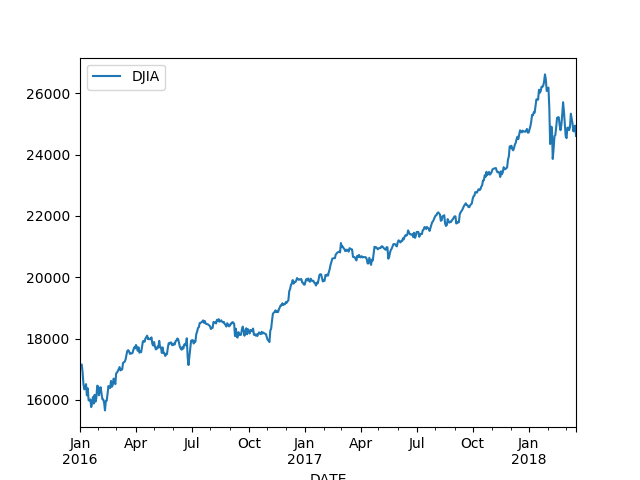

In [5]:
#Plotting didn't work right away because not all dates have values.
#I went ahead and filled all missing values with the most recent data
f.ffill(inplace=True)
f.plot()

So we can see the price fluctuate over time. If we want to play around with Bolinger bands, we have to take a rolling average of all these values. We then look at how the real price compares to this average. We must decide arbitrarily how far we want to average our data. 20 days seems to be the standard.

<IPython.core.display.Javascript object>


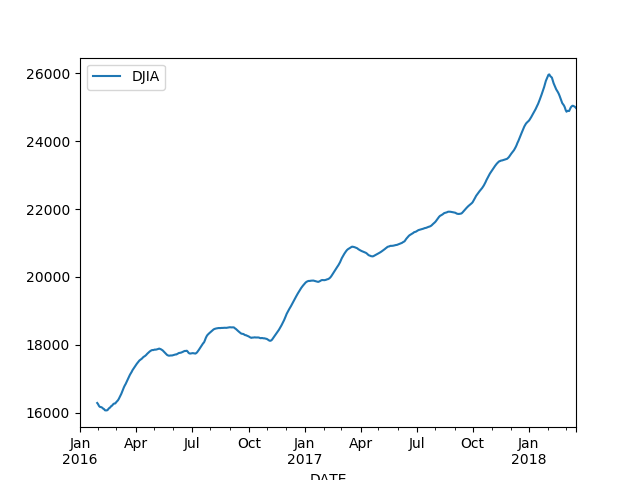

In [6]:
#Here is the average. It looks a lot nicer.
f_mean = f.rolling(20).mean()
f_mean.plot()

<IPython.core.display.Javascript object>


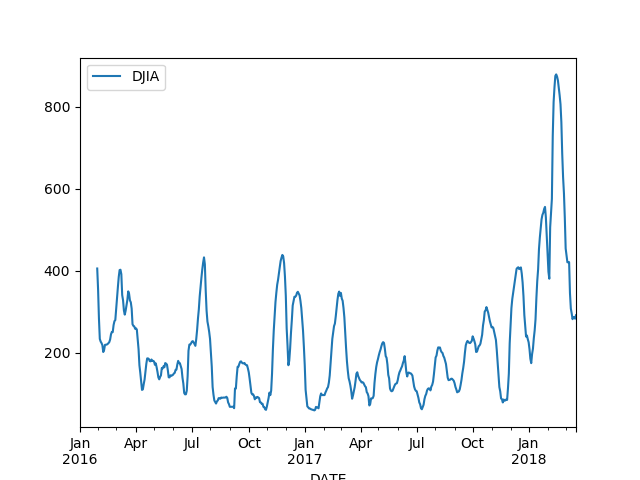

In [7]:
#We can also easily take a look at the rolling standard deviation
f_std = f.rolling(20).std()
f_std.plot()

In [8]:
#Let's go ahead and overlay all three traces and we get this
f['mean'] = f_mean
f['std_high'] = (f_mean + 2*f_std)
f['std_low'] = (f_mean - 2*f_std)

In [9]:
f.tail()

,DJIA,mean,std_high,std_low
DATE,,,,
2018-03-13,25007.03,25041.9995,25606.689685,24477.309315
2018-03-14,24758.12,25035.2310,25610.561115,24459.900885
2018-03-15,24873.66,25018.8955,25593.034644,24444.756356
2018-03-16,24946.51,25005.2520,25572.255680,24438.248320
2018-03-19,24610.91,24974.8285,25558.507503,24391.149497


<IPython.core.display.Javascript object>


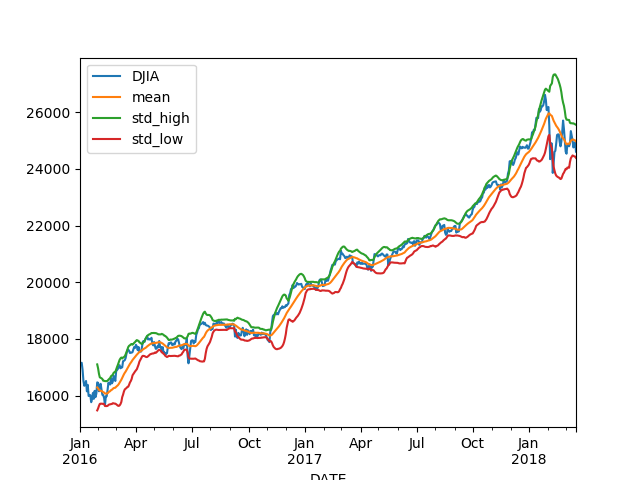

In [10]:
f.plot()

In [11]:
#Let's look at a specific stock
fb = web.DataReader('FB', 'robinhood', start, end)
fb.head()

close_price high_price  interpolated low_price open_price  \
symbol begins_at                                                              
FB     2017-04-13    139.3900   140.5800         False  139.3300   139.6200   
       2017-04-17    141.4200   141.5500         False  139.7500   139.7600   
       2017-04-18    140.9600   141.9050         False  140.6100   141.2700   
       2017-04-19    142.2700   143.0400         False  141.2700   141.3500   
       2017-04-20    143.8000   144.2500         False  142.6890   142.9500   

                  session    volume  
symbol begins_at                     
FB     2017-04-13     reg  10965614  
       2017-04-17     reg  11519663  
       2017-04-18     reg  14807472  
       2017-04-19     reg  15563945  
       2017-04-20     reg  15968164

In [12]:
fb = fb[['close_price']]
fb.head()

close_price
symbol begins_at             
FB     2017-04-13    139.3900
       2017-04-17    141.4200
       2017-04-18    140.9600
       2017-04-19    142.2700
       2017-04-20    143.8000

In [13]:
#Let's consolidate some of our work and put all that in a function
import numpy as np
def bolband(df, win=20, std_fact=2):
    f.ffill(inplace=True)
    #Robinhood gave me not number data, so I converted that over.
    df = df.astype(np.float32)
    mean = df.rolling(win).mean()
    std = df.rolling(win).std()
    df['mean'] = mean
    df['std_high'] = (mean + std_fact*std)
    df['std_low'] = (mean - std_fact*std)
    return df

<IPython.core.display.Javascript object>


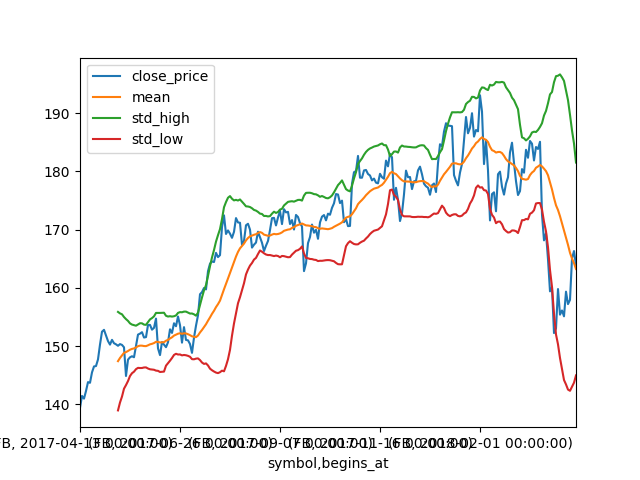

In [14]:
fb_bolband = bolband(fb, std_fact=2)
fb_bolband.plot()
plt.show()

I used to hear that a strategy was to buy when the price hit the lower Bolinger band and then sell when it got high or went back to the mean. You can see why this might be a bad strategy, but we will code it up anyway, because we mostly just want practice coding.

In [15]:
#Here I'm using an objec to keep track of my profits over time
#with this strategy.
class MoneyTracker():
    
    def __init__(self):
        self.total_earnings_ratio = 1.0
        self.curr_trade_price = None
        
    def __call__(self, price, mean, std_low, std_high):
        if self.curr_trade_price == None and price < std_low:
            self.curr_trade_price = price
            return self.total_earnings_ratio
        elif self.curr_trade_price != None and price > mean:
            self.total_earnings_ratio *= price / self.curr_trade_price
            self.curr_trade_price = None
            return self.total_earnings_ratio
        elif self.curr_trade_price == None:
            return self.total_earnings_ratio
        else:
            return self.total_earnings_ratio * (price / self.curr_trade_price)

In [16]:
ls = []
mt = MoneyTracker()
for i, row in fb_bolband.iterrows():
    price, mean, std_high, std_low = row['close_price'], row['mean'], row['std_high'], row['std_low']
    curr_earnings_ratio = mt(price, mean, std_low, std_high)
    ls.append(curr_earnings_ratio)

In [17]:
fb_bolband['earnings'] = ls

<IPython.core.display.Javascript object>


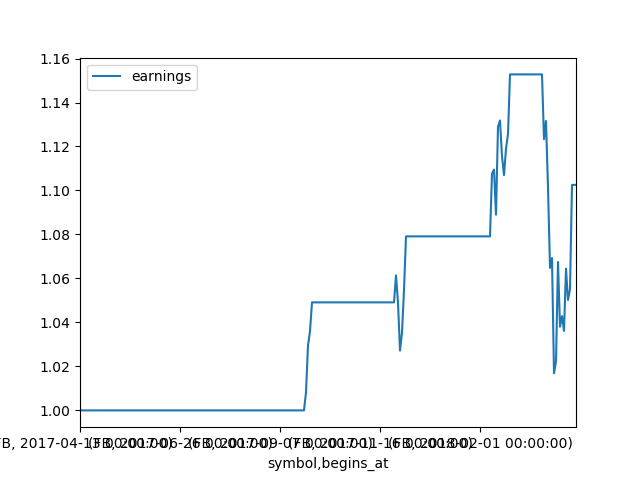

In [18]:
fb_bolband[['earnings']].plot()
plt.show()

Given that this is over the course of over 2 years, 15% isn't very good returns. We didn't even beat the SPY over the last year! If we had just stuck with the stock and let it go, we would have had 180/140 or 28% returns over last year, otherwise we would have doubled our money over 2 years. This in itself is not obviously a great investing strategy and you can pick apart reasons why this might be. Should we be shorting the stock when it is high? should be we keeping track of the slope of the stock when the price veers from the mean as well? Should we be looking at other stocks? Should we be trying to play multiple stocks against each other? How do options play into this? Should we try different window sizes and standard deviations? There are a lot of cool questions we can ask. If we wanted to try any different trading strategies, we could add that logic to our MoneyTracking code, or exapnd it to handle multiple stocks.

If we were interested in continuing finance examples, we could find ways of doing a lot better than this. However, we are going to stop this example and dive into how to write Python code, and then build up our knowledge so we know how everything that we wrote here works.